In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_cos_graphsage_linkpred_09_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fb5651a7b10> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(11398)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

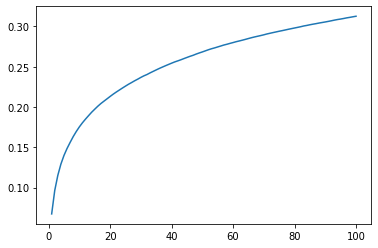

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.0673, 0.0964, 0.1152, 0.1291, 0.1398, 0.1485, 0.1560, 0.1632, 0.1696,
        0.1753, 0.1804, 0.1850, 0.1893, 0.1935, 0.1973, 0.2010, 0.2043, 0.2072,
        0.2101, 0.2131, 0.2159, 0.2186, 0.2210, 0.2235, 0.2259, 0.2283, 0.2304,
        0.2326, 0.2346, 0.2368, 0.2387, 0.2403, 0.2424, 0.2442, 0.2461, 0.2479,
        0.2496, 0.2512, 0.2528, 0.2544, 0.2559, 0.2572, 0.2586, 0.2601, 0.2615,
        0.2629, 0.2642, 0.2657, 0.2671, 0.2684, 0.2697, 0.2711, 0.2723, 0.2734,
        0.2746, 0.2757, 0.2769, 0.2779, 0.2790, 0.2800, 0.2811, 0.2820, 0.2829,
        0.2840, 0.2850, 0.2860, 0.2870, 0.2878, 0.2887, 0.2896, 0.2907, 0.2915,
        0.2924, 0.2932, 0.2941, 0.2948, 0.2957, 0.2965, 0.2973, 0.2981, 0.2989,
        0.2997, 0.3006, 0.3013, 0.3021, 0.3028, 0.3035, 0.3043, 0.3049, 0.3056,
        0.3063, 0.3071, 0.3079, 0.3086, 0.3092, 0.3099, 0.3107, 0.3113, 0.3120,
        0.3127])

In [18]:
percentages.max()

tensor(0.3127)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.52164542, 0.50405095, 0.49304075, 0.48428781, 0.47774517,
       0.47235788, 0.4677084 , 0.4638559 , 0.46064824, 0.45769887,
       0.45508927, 0.45263853, 0.4504708 , 0.44847946, 0.44658514,
       0.4447438 , 0.44306943, 0.44153877, 0.44012572, 0.43871314,
       0.43743003, 0.43613741, 0.43494256, 0.43381406, 0.43275624,
       0.43171142, 0.43075647, 0.4297841 , 0.42884071, 0.42793581,
       0.42705671, 0.42617793, 0.42536065, 0.42452996, 0.42377946,
       0.42306049, 0.42231607, 0.42159062, 0.42090813, 0.42023511,
       0.41953645, 0.41886627, 0.41821834, 0.41759517, 0.41697567,
       0.41638106, 0.4157645 , 0.41519874, 0.4146416 , 0.41409246,
       0.41354726, 0.41303994, 0.41252782, 0.41204516, 0.41155525,
       0.41107239, 0.41059343, 0.41013719, 0.40965668, 0.40916808,
       0.40868824, 0.40823349, 0.40779918, 0.40736442, 0.40691478,
       0.40650561, 0.40607718, 0.40566588, 0.40526401, 0.40485962,
       0.4044628 , 0.40407692, 0.40370088, 0.40332415, 0.40296

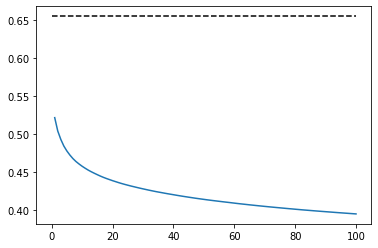

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fb5500a9660> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(17846)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.7975186327821575

In [37]:
max_k = 100
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [38]:
indices

array([[     0,  10839,  87652, ...,  20012, 142605, 135035],
       [     1, 154949,  39967, ...,  18151,  23076, 106784],
       [     2,  65576, 121728, ..., 132588,   9717,  63974],
       ...,
       [169340,  40359, 152563, ...,  68061, 126023, 121048],
       [169341,  46262,  63616, ..., 167492, 110544, 166159],
       [169342, 165534,  13442, ...,   7935,  60782,  83415]])

In [39]:
sum(emb_norm[0] * emb_norm[411])

0.595037265564315

In [40]:
distances

array([[1.        , 0.96264267, 0.9533403 , ..., 0.73025787, 0.73022395,
        0.72959083],
       [1.0000001 , 0.9999994 , 0.9999878 , ..., 0.99997675, 0.99997663,
        0.99997663],
       [1.0000001 , 0.99998987, 0.9999886 , ..., 0.99996686, 0.99996686,
        0.99996656],
       ...,
       [1.0000001 , 0.994744  , 0.99455506, ..., 0.9900042 , 0.9899824 ,
        0.98997927],
       [0.9999999 , 0.9946665 , 0.99360377, ..., 0.97842216, 0.9783178 ,
        0.9782674 ],
       [1.        , 0.9999317 , 0.9999269 , ..., 0.99985325, 0.99985313,
        0.9998531 ]], dtype=float32)

In [41]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [42]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

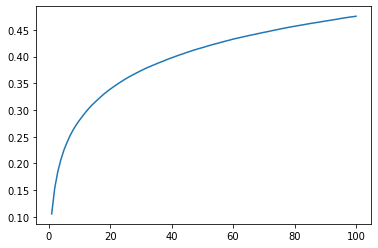

In [43]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [44]:
percentages

tensor([0.1053, 0.1539, 0.1846, 0.2071, 0.2251, 0.2393, 0.2521, 0.2629, 0.2721,
        0.2805, 0.2880, 0.2955, 0.3023, 0.3087, 0.3141, 0.3195, 0.3248, 0.3299,
        0.3344, 0.3388, 0.3430, 0.3469, 0.3508, 0.3544, 0.3581, 0.3614, 0.3646,
        0.3676, 0.3706, 0.3735, 0.3763, 0.3790, 0.3815, 0.3839, 0.3862, 0.3887,
        0.3909, 0.3932, 0.3956, 0.3977, 0.3998, 0.4019, 0.4039, 0.4057, 0.4079,
        0.4097, 0.4117, 0.4134, 0.4152, 0.4168, 0.4184, 0.4202, 0.4220, 0.4235,
        0.4250, 0.4266, 0.4281, 0.4296, 0.4311, 0.4327, 0.4340, 0.4353, 0.4366,
        0.4379, 0.4392, 0.4404, 0.4416, 0.4429, 0.4441, 0.4454, 0.4464, 0.4477,
        0.4489, 0.4501, 0.4513, 0.4525, 0.4536, 0.4547, 0.4557, 0.4568, 0.4578,
        0.4588, 0.4598, 0.4608, 0.4619, 0.4628, 0.4637, 0.4646, 0.4656, 0.4665,
        0.4674, 0.4684, 0.4693, 0.4703, 0.4713, 0.4723, 0.4731, 0.4740, 0.4747,
        0.4756])

### Percentage of same class neighbors by neighborhood size

In [45]:
ind_labels = label_transform(indices)

In [46]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [47]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [48]:
perc_same_class = n_same_class / n_total

In [49]:
perc_same_class

array([0.56900492, 0.55041543, 0.53734728, 0.52798315, 0.52052343,
       0.5148338 , 0.50969925, 0.50508657, 0.50118268, 0.49789362,
       0.49470333, 0.4919355 , 0.48961575, 0.48743801, 0.4853656 ,
       0.48344521, 0.48171636, 0.4799936 , 0.47839499, 0.47688006,
       0.47547258, 0.47421291, 0.47295314, 0.47172159, 0.47055904,
       0.46945548, 0.46842973, 0.46735324, 0.46637217, 0.46543209,
       0.46450542, 0.46363501, 0.46279033, 0.46198474, 0.46119313,
       0.46046469, 0.45975951, 0.45907046, 0.45839161, 0.45774833,
       0.45709653, 0.45643753, 0.45579132, 0.45517744, 0.4545856 ,
       0.45401512, 0.45347972, 0.45293244, 0.45235241, 0.45182582,
       0.45133574, 0.45083738, 0.4503811 , 0.44989339, 0.44941794,
       0.44897824, 0.44850662, 0.44805167, 0.44758292, 0.44714751,
       0.44672434, 0.44633672, 0.44593433, 0.44552725, 0.44514815,
       0.44474233, 0.44436255, 0.44398907, 0.44362317, 0.44325102,
       0.44289625, 0.44252904, 0.44218911, 0.44184568, 0.44151

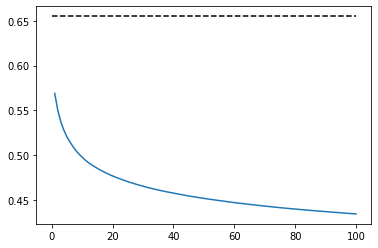

In [50]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Inner Product

In [57]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [58]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [59]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fb5384f1db0> >

In [60]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [61]:
distances, indices = index_ip.search(embeddings, 2)

In [62]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(11720)

In [63]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [64]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

3.712745566153899

In [65]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [66]:
indices

array([[ 41480, 154342, 147834, ..., 149111, 165736,  80881],
       [156590, 129875,  71544, ..., 154315,  93556,  89650],
       [ 83597,  49005,  10717, ..., 167076, 117968,   1555],
       ...,
       [ 83791,  99184,  29729, ...,  16300,   4689,  57320],
       [ 65455,  70820, 123288, ...,    508, 130150, 118578],
       [104852,  77164, 159086, ...,  36296,    133, 159292]])

In [67]:
sum(embeddings[0] * embeddings[411])

6.425491132307798

In [68]:
distances

array([[6.01847115e+01, 5.77551231e+01, 5.58581085e+01, ...,
        4.02448654e+01, 4.01447906e+01, 4.01212502e+01],
       [3.28552852e+04, 3.27628066e+04, 2.97658535e+04, ...,
        2.43042305e+04, 2.42587656e+04, 2.42415293e+04],
       [1.07416572e+04, 1.06725205e+04, 1.04863193e+04, ...,
        8.84966992e+03, 8.84629492e+03, 8.84281250e+03],
       ...,
       [7.17712524e+02, 7.09762024e+02, 7.09172241e+02, ...,
        4.51975983e+02, 4.51800995e+02, 4.50365326e+02],
       [9.53558731e+00, 9.27064133e+00, 9.20972538e+00, ...,
        7.20513725e+00, 7.20075846e+00, 7.19771051e+00],
       [1.24115996e+04, 1.13098984e+04, 1.12155107e+04, ...,
        8.12298047e+03, 8.11475391e+03, 8.11391016e+03]], dtype=float32)

In [69]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [70]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

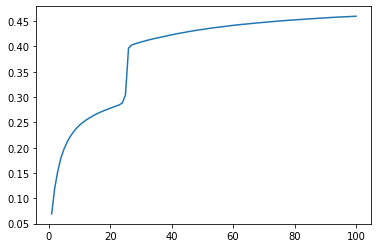

In [71]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [72]:
percentages

tensor([0.0692, 0.1204, 0.1540, 0.1796, 0.1970, 0.2107, 0.2217, 0.2304, 0.2379,
        0.2441, 0.2490, 0.2538, 0.2577, 0.2612, 0.2647, 0.2678, 0.2705, 0.2731,
        0.2754, 0.2777, 0.2801, 0.2823, 0.2845, 0.2886, 0.3039, 0.3966, 0.4025,
        0.4048, 0.4066, 0.4085, 0.4102, 0.4118, 0.4135, 0.4149, 0.4162, 0.4174,
        0.4188, 0.4201, 0.4215, 0.4227, 0.4240, 0.4253, 0.4263, 0.4274, 0.4285,
        0.4296, 0.4306, 0.4316, 0.4326, 0.4334, 0.4343, 0.4352, 0.4361, 0.4370,
        0.4377, 0.4385, 0.4392, 0.4400, 0.4407, 0.4415, 0.4422, 0.4428, 0.4435,
        0.4439, 0.4446, 0.4452, 0.4458, 0.4464, 0.4469, 0.4474, 0.4480, 0.4485,
        0.4490, 0.4495, 0.4501, 0.4505, 0.4510, 0.4515, 0.4519, 0.4522, 0.4527,
        0.4532, 0.4535, 0.4540, 0.4544, 0.4548, 0.4551, 0.4556, 0.4559, 0.4563,
        0.4567, 0.4571, 0.4574, 0.4577, 0.4581, 0.4583, 0.4586, 0.4589, 0.4592,
        0.4595])

### Percentage of same class neighbors by neighborhood size

In [73]:
ind_labels = label_transform(indices)

In [74]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [75]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [76]:
perc_same_class = n_same_class / n_total

In [77]:
perc_same_class

array([0.60913058, 0.59804657, 0.535434  , 0.55675906, 0.56943482,
       0.57739519, 0.59114342, 0.60301873, 0.59072809, 0.57990764,
       0.58754019, 0.5943829 , 0.59517892, 0.5765395 , 0.57468924,
       0.56774564, 0.56286145, 0.55580587, 0.55452978, 0.55168238,
       0.55623118, 0.55222349, 0.55314259, 0.55723394, 0.56099703,
       0.56386424, 0.56346127, 0.56623202, 0.56749625, 0.56821402,
       0.57030977, 0.57264897, 0.5736854 , 0.57405002, 0.57548273,
       0.57271813, 0.57100837, 0.5708133 , 0.5716515 , 0.57442085,
       0.57559524, 0.57650815, 0.57744451, 0.57784953, 0.57491954,
       0.57135325, 0.56808685, 0.56460901, 0.56454193, 0.56194493,
       0.56227893, 0.56171157, 0.56154301, 0.56050715, 0.55893617,
       0.55912282, 0.55826807, 0.5585492 , 0.55973179, 0.56086513,
       0.56022218, 0.56092197, 0.55917693, 0.55889664, 0.55809588,
       0.55845792, 0.5596171 , 0.55924566, 0.56022144, 0.55943246,
       0.56000643, 0.56103794, 0.56029236, 0.56016743, 0.56109

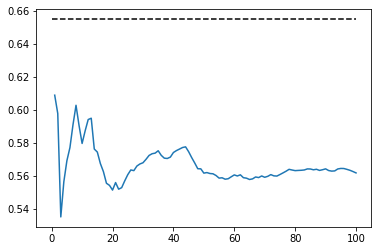

In [78]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [51]:
pca = PCA(n_components=2)

In [52]:
pca.fit(embeddings)

PCA(n_components=2)

In [53]:
emb_2d = pca.transform(embeddings)

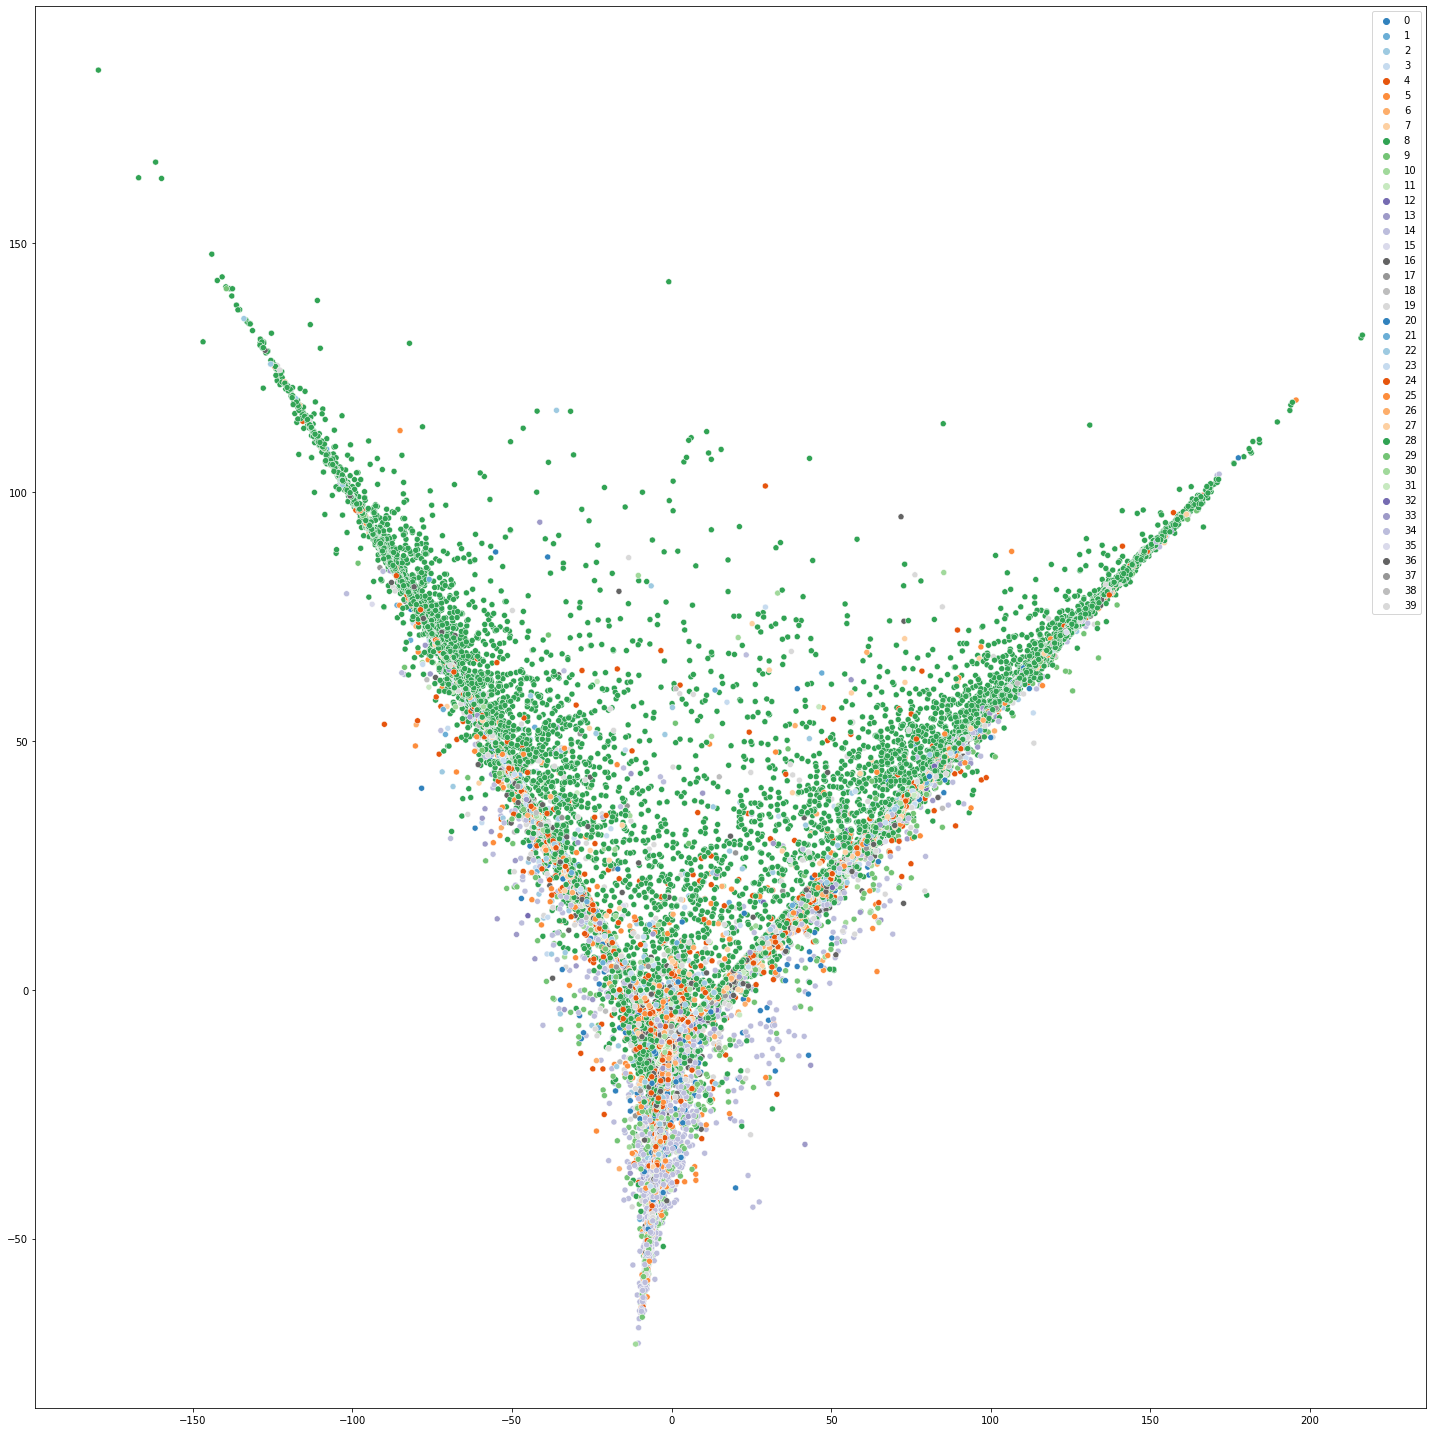

In [54]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [55]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

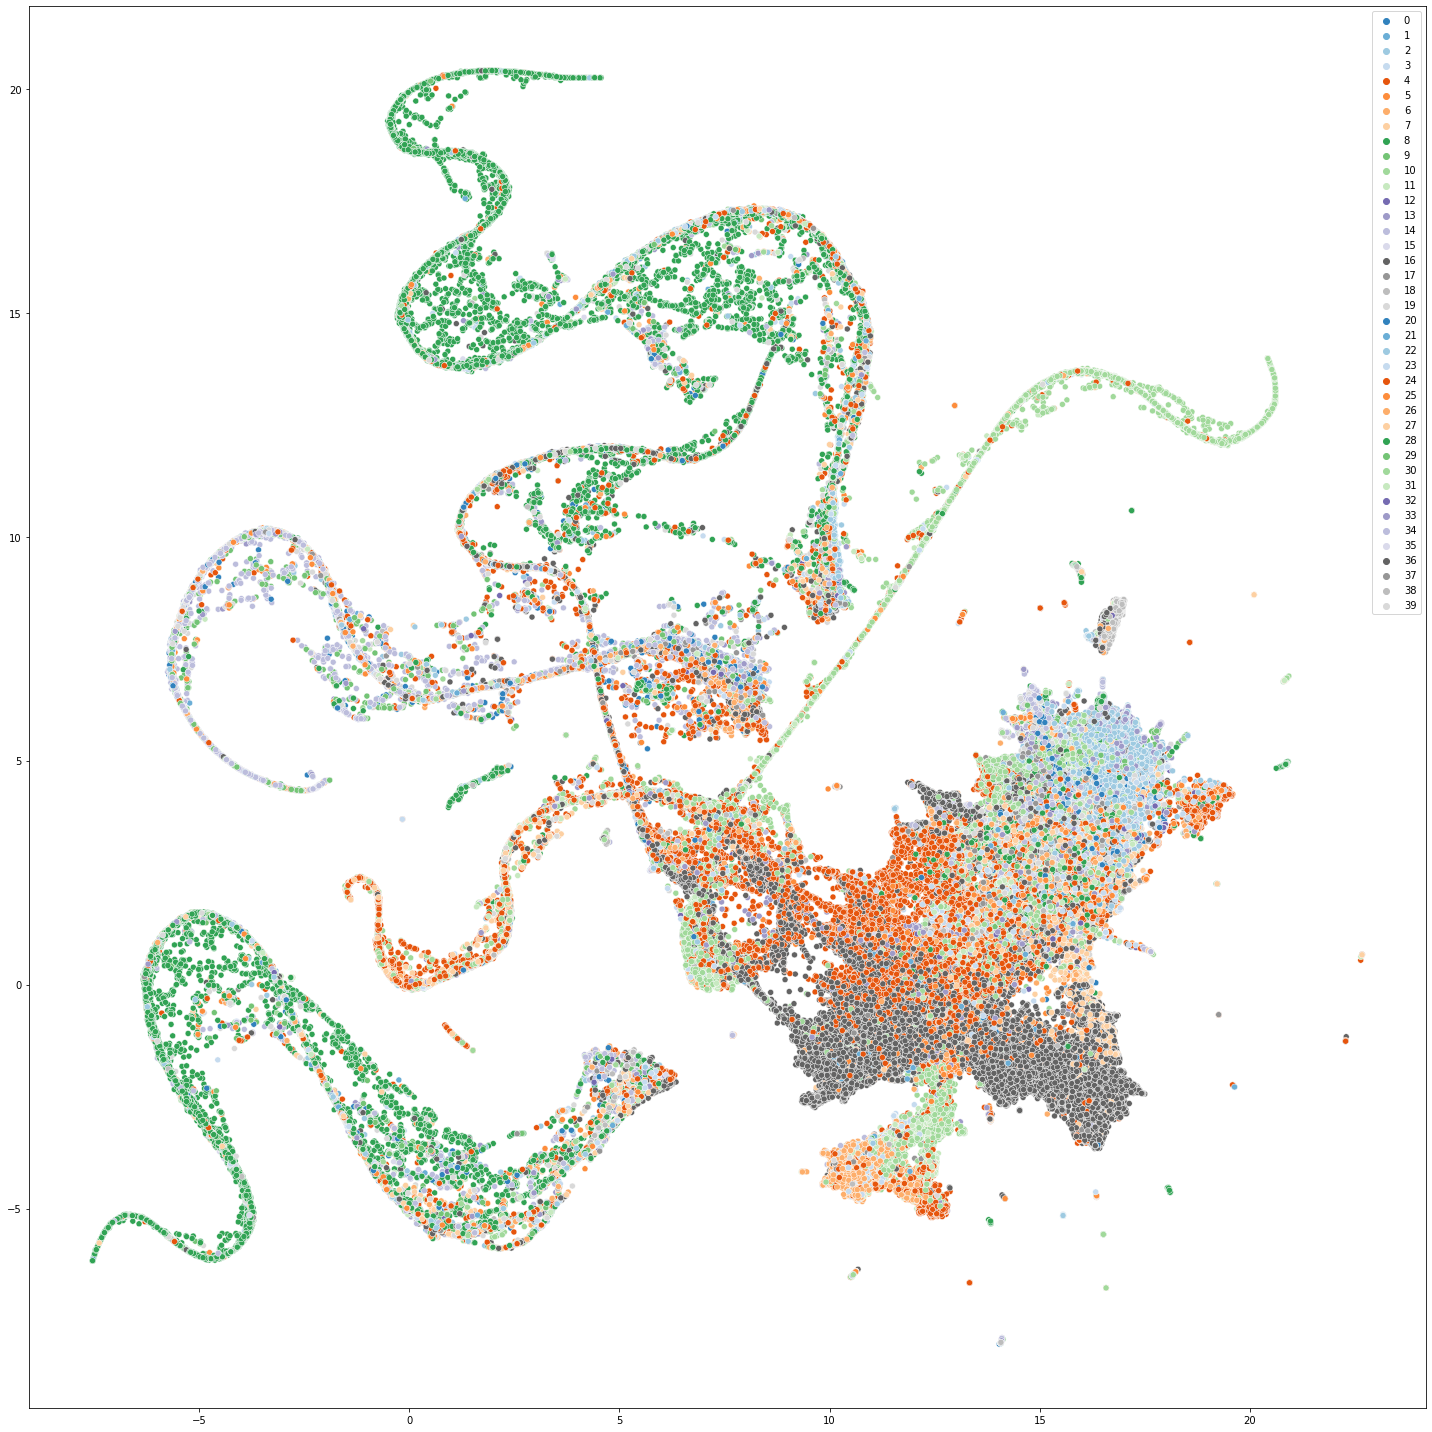

In [56]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [79]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

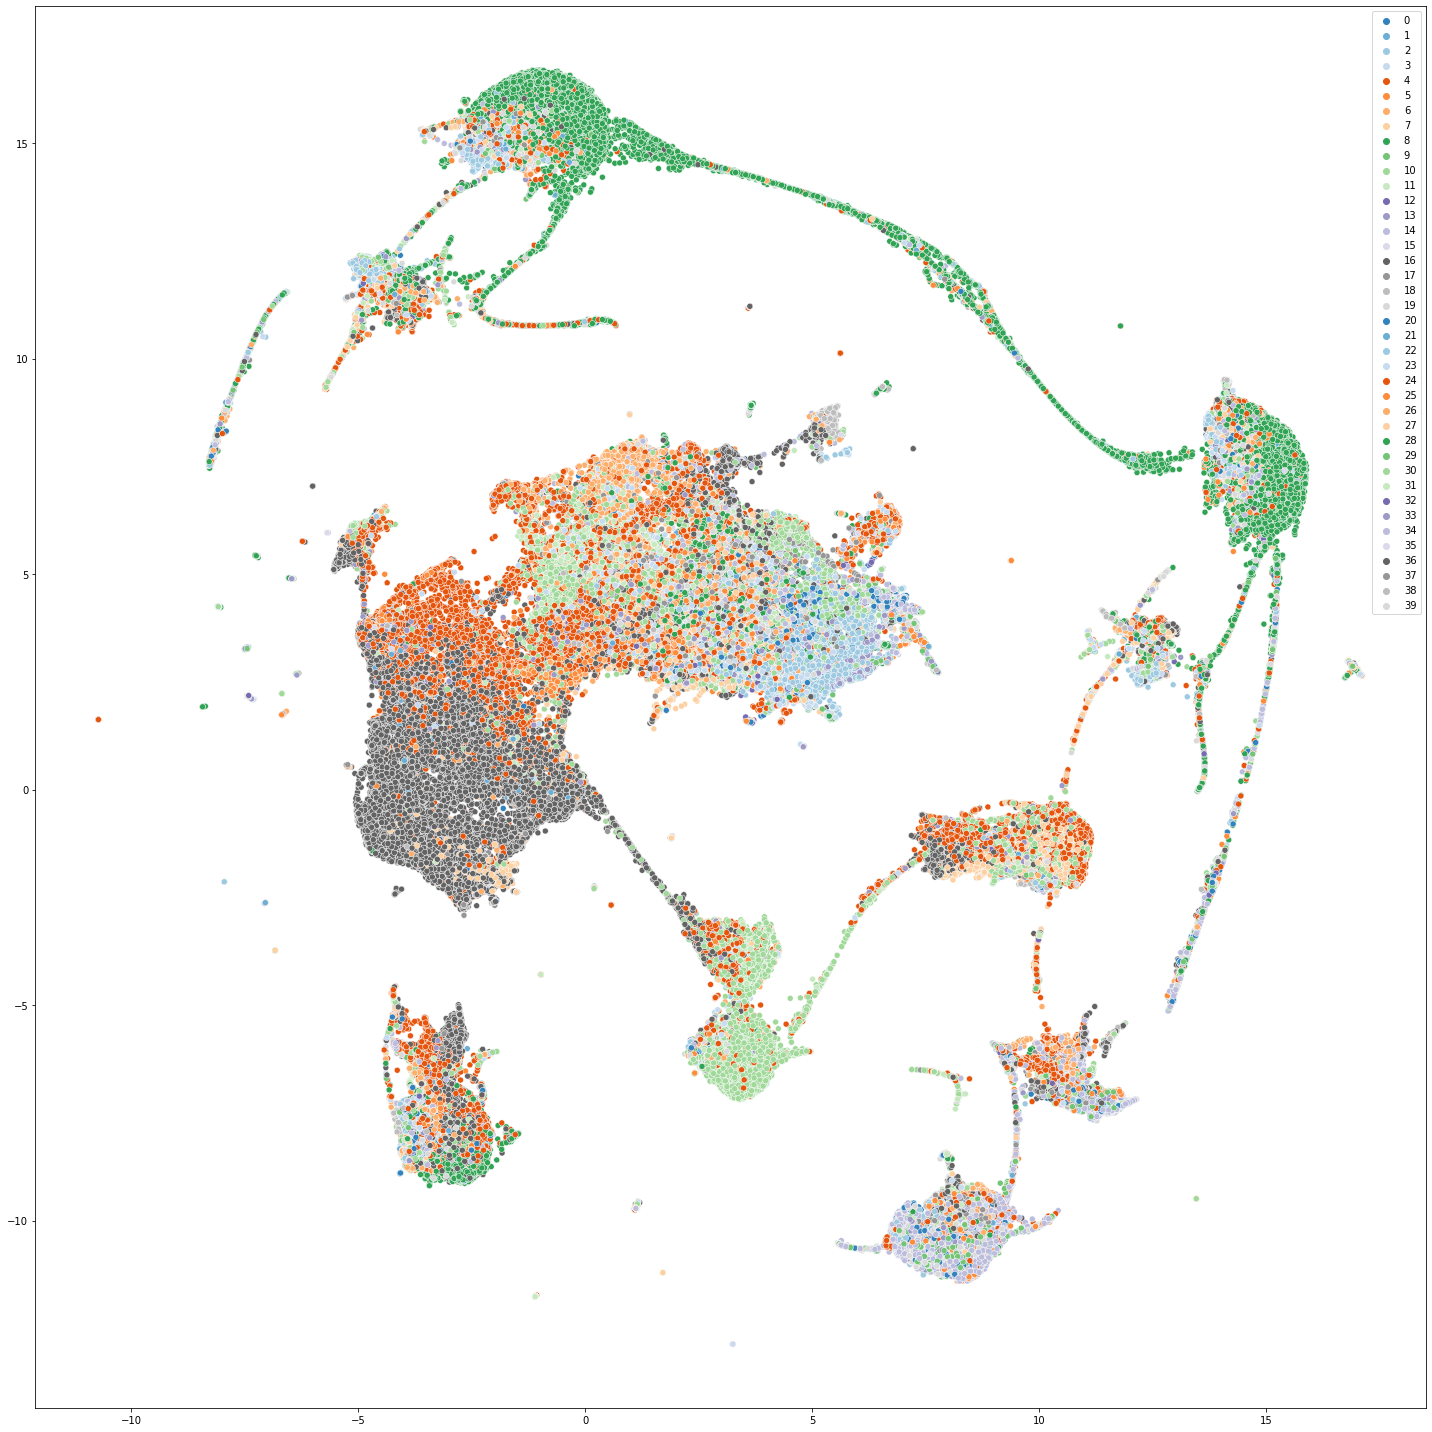

In [80]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()